## 金融贷款数据分析

### 案例简介
Prosper是美国的一家P2P在线借贷平台，网站撮合了一些有闲钱的人和一些急用钱的人。用户若有贷款需求，可在网站上列出期望数额和可承受的最大利率。潜在贷方则为数额和利率展开竞价。 本项目拟通过该数据集的探索，结合自己的理解进行分析，最终目的的是初步预测哪些人贷款逾期还款。

ListingCreation: 列表创建时间。 

Term: 贷款期限，期限越长的，利率应当越高 

LoanStatus: 贷款状态（Completed、Current、Defaulted、Chargedoff等） 

BorrowerBorrowerRate: 借款利率。 

DelinquenciesLast7Years: 信用资料提交时借款人过去7年违约次数。 

StatedMonthlyIncome: 客户自己声称的月收入。 

IsBorrowerHomeowner: 借款人是否拥有住房。 

InquiriesLast6Months: 最近6个月的征信记录查询次数。一般来说，征信查询次数越多，该主体的贷款申请就越多。 

DebtToIncomeRatio: 借款人的债务收入比，债务收入比越高说明筹资者财务状况越差，还款能力越低。 

Occupation: 贷款人职业 

CreditGrade/ProsperRating(Alpha): 信用等级，前者反映的是2009年7月1日前客户的信用等级，后者反映的是2009年7月1日后的信用等级。信用等级越高，其偿债能力越强。 

CreditScore: 由消费信用公司提供的消费信用评分，同信用评级作用。 

BankCardUse: 信用资料提交时借款人信用卡使用额度和信用卡总透支额度的百分比，本文将这个数据分成四组（mild use; medium use; heavy use; super use）

### 数据预处理
1. 筛选数据集
LoanStatus: 贷款状态 
步骤： 针对LoanStatus进行重构 
1.将所有含有“Past Due”、“Cancelled”、“defaulted”、“Chargedoff”转换为1，表示逾期 
2.将“FinalPaymentInProgress”、“Completed”转换为0，表示未逾期 
3.将“Current”转换为2，表示正在进行的样本，作为预测集 
筛选出借款日期在2009年7月之后的样本作为本项目的数据集
2. 删除无效变量
3. 处理缺失值
4. 整合BankcardUtilization，IncomeRange等变量

In [22]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv(r"F:\文档\python\load_data\prosperLoanData.csv",engine="python")
df.rename(str.lower,axis='columns',inplace=True)
map_name = {'prosperrating (numeric)':'prosperrating','listingcategory (numeric)':'listingcategory','tradesneverdelinquent (percentage)':'tradesneverdelinquent'}
df.rename(columns=map_name,inplace=True)
# print(df.info())
# print(df.describe())
print("本数据集有{}行，{}列".format(df.shape[0],df.shape[1]))
# 由于该借贷平台在2009年7月前后有较大的政策变更，所以我们只取新政策实施阶段的样本，即借款日期在2009年7月之后的样本


# 借款日期
df.loanoriginationdate = pd.to_datetime(df.loanoriginationdate.apply(lambda p:p.split(" ")[0]),format="%Y/%m/%d")
# 初次打开额度时间
df.firstrecordedcreditline = pd.to_datetime(df.firstrecordedcreditline,format="%Y/%m/%d")
# 信用档案被提取的日期
df.datecreditpulled = pd.to_datetime(df.datecreditpulled.apply(lambda p:p.split(" ")[0] if len(p)>10 else np.nan),format="%Y/%m/%d")

# df.LoanStatus.value_counts()
def status(loanstatus):
    if "Past Due" in loanstatus or loanstatus=="Cancelled" or loanstatus=="defaulted" or loanstatus=="Chargedoff":
        return 1
    elif loanstatus=="FinalPaymentInProgress" or loanstatus=="Completed":
        return 0
    else:
        return 2
df['loanstatus'] = df.loanstatus.apply(status)
# print(df[df.loanoriginationdate >= datetime.datetime.strptime('2009-07-01','%Y-%m-%d')].shape)
# print(df[df.loanoriginationdate < datetime.datetime.strptime('2009-07-01','%Y-%m-%d')].shape)
# 2009年7月1日之前的借款样本有28953个，之后的样本有84984。我们舍弃了2009年7月1日之前的借款样本
# 筛选出借款日期在2009年7月之后的样本集
dataset = df[df.loanoriginationdate >= datetime.datetime.strptime('2009-07-01','%Y-%m-%d')]
print("筛选后的数据集有{}行，{}列".format(dataset.shape[0],dataset.shape[1]))

# 截至时间
# dataset.ClosedDate = pd.to_datetime(dataset.ClosedDate,errors="ignore")
# dataset.columns

本数据集有113937行，81列
筛选后的数据集有84984行，81列


#### 删除无效变量

In [23]:
# 有些缺失值代表0所以不能直接删除缺失值，用0填充即可
col = ['totalprosperpaymentsbilled','ontimeprosperpayments','prosperpaymentslessthanonemonthlate','prosperpaymentsonemonthpluslate','prosperprincipalborrowed',
'prosperprincipaloutstanding','scorexchangeattimeoflisting',"loancurrentdaysdelinquent", 'loanfirstdefaultedcyclenumber']
dataset[col] = dataset[col].fillna(value=0)
dataset.isnull().sum()[dataset.isnull().sum()!= 0]

# 删除无关变量(id或者时间)
# 贷款发放的季度。因为已有LoanOriginationDate贷款发放的日期，所以这个特征可舍弃
# 借款人职业中，不想透露职业的人数占多数，所以这个特征价值不大
unrelated_columns = ['listingkey',"listingnumber","listingcreationdate","currentlyingroup","groupkey",
"loankey","memberkey","loannumber","creditgrade",'loanoriginationquarter','employmentstatusduration',"occupation"]
dataset.drop(columns=unrelated_columns,axis=1,inplace=True)

dataset.shape
# (84984, 69)

(84984, 69)

#### 整合变量

(84984, 72)

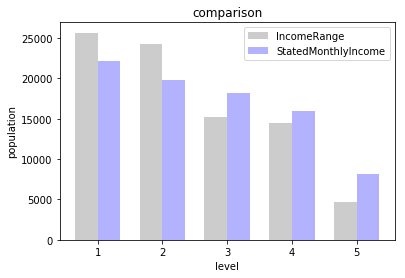

In [24]:
%matplotlib inline
# dataset.info()

# 信用卡使用额度：BankcardUtilization
# 将BankcardUtilization数据根据透支程度分成四组（mild use 为1; medium use 为2; heavy use 为3; super use 为4）
# print(dataset.BankcardUtilization.describe())
section = [0,0.220000,0.540000, 0.820000,2.500000]
labels = [1,2,3,4]
dataset.bankcardutilization = pd.cut(dataset.bankcardutilization,section,labels=labels)


dataset.groupby('incomeverifiable').agg({'statedmonthlyincome':['min','mean','max']}).reset_index()
# 根据是否有收入证明分组,得到的月收入情况，没有收入证明的最大值偏大，平均值偏小，有收入证明的收入更具有可信度
# IncomeVerifiable
# False    4539.335875
# True     5649.850354
# Name: StatedMonthlyIncome, dtype: float64

# 首先查看StatedMonthlyIncome月收入数据概况，是否有异常值
# 绘制箱线图

# plt.boxplot(dataset.statedmonthlyincome[(dataset.statedmonthlyincome<=60000) & (dataset.statedmonthlyincome>1000)],showmeans=True)
# 发现较多异常值，为了减小方差，我们对贷款人的月收入进行离散化，去除极端值的影响
# 对月收入进行离散化
section= [0,3166,4583,6524,10000,620000]
# # 1代表超低收入，2代表低收入，3代表中收入，4代表高收入，5代表超高收入
labels = [1,2,3,4,5]
dataset.statedmonthlyincome = pd.cut(dataset.statedmonthlyincome,section,labels=labels)

# 年收入范围：IncomeRange
# 取范围平均值
def incomerange(IncomeRange):
    if IncomeRange == "$25,000-49,999":
        return (49999+25000)/2
    elif IncomeRange == "$75,000-99,999":
        return (99999+75000)/2
    elif IncomeRange == "$50,000-74,999":
        return (74999+50000)/2 
    elif IncomeRange == "$100,000+":
        return 100000  
    elif IncomeRange == "$1-24,999":
        return 25000/2
    else:
        return 0
# $25,000-49,999    8683
# $50,000-74,999    7757
# $75,000-99,999    4268
# $100,000+         4233
# $1-24,999         2040
# Not employed       386
# $0                  33
# print(dataset.IncomeRange.value_counts())
dataset.incomerange = dataset.incomerange.apply(incomerange)
dataset.incomerange.fillna(value=dataset.incomerange.mean(),inplace=True)

dataset.groupby('incomeverifiable').agg({'incomerange':['min','mean','max']}).reset_index()
section= [0,12500,37499.5,62499.5,87499.5,100000.0]
# # 1代表超低收入，2代表低收入，3代表中收入，4代表高收入，5代表超高收入
labels = [1,2,3,4,5]
dataset.incomerange = pd.cut(dataset.incomerange,section,labels=labels)
# print(dataset.incomerange.value_counts())
# 2    8683
# 3    7757
# 4    4268
# 5    4233
# 1    2040
# Name: IncomeRange, dtype: int64
# 发现对比月收入，年收入会更可靠一些，后期将删除月收入保留年收入

# 查看月收入水平和年收入水平的分布情况
ind = np.arange(len(dataset.incomerange.value_counts()))
width = 0.35

incomerange = plt.bar(ind,dataset.incomerange.value_counts(),width,color="k",alpha=0.2,label="IncomeRange")
statedmonthlyincome = plt.bar(ind+width,dataset.statedmonthlyincome.value_counts(),width,color="b",alpha=0.30,label="StatedMonthlyIncome")
plt.ylabel("population")
plt.xlabel("level")
plt.title("comparison")
locations= ind+width/2
labels = ['1', '2', '3', '4', '5']
plt.xticks(locations,labels)
plt.xlim()
plt.legend()
# 由于切分的规则不同,月收入分布的更均匀一些
# 年收入中处于超低收入区间的人数偏多,收入水平越高,人数越少,
# 但是年收入的各个水平之间的差距更大,月收入因为极端值偏多,大部分人都处于4000-6000之间
## 删除'StatedMonthlyIncome'月收入特征,是否有收入证明,职业,地址状态等
dataset.drop(columns=['statedmonthlyincome','incomeverifiable','borrowerstate','prosperrating (alpha)'],axis=1,inplace=True)
## 将分类变量BankcardUtilization，IncomeRange转化为数值变量
dataset = pd.get_dummies(dataset,columns=['bankcardutilization','incomerange'],prefix=["bankcardutilization_level_","incomerange_level_"])
dataset.shape
# (84984, 72)

In [26]:
# TotalProsperLoans 借款人在创建此列表时对Prosper贷款的按时还款数量。
# 如果借款人没有先前的贷款，这个值将为空。该列大部分都为空值，只有8684个人之前有过贷款
dataset.totalprosperloans.fillna(value=0,inplace=True)
# 可以再添加一个新特征loans_before，为之前是否有过贷款
dataset['loans_before'] = dataset.totalprosperloans.apply(lambda x:1 if x >0 else 0)


## 对分类变量EmploymentStatus进行整合，
# Employed         17763
# Full-time         6475
# Self-employed     1408
# Other              870
# Not employed       386
# Retired            264
# Part-time          234
# Name: EmploymentStatus, dtype: int64
# 根据分类，可以将Full-time和Employed 归为同一类working，
# Not employed和Retired归为同一类no_work
# Part-time 和Other、Self-employed归为同一类free_work

def employmentstatus(status):
    if status=="Employed" or status=="Full-time":
        return 'working'
    elif status=="Not employed" or status=="Retired":
        return 'no_work'
    elif status=="Other":
        return 'no_show_status'
    else:
        return 'free_work'
dataset.employmentstatus = dataset.employmentstatus.apply(employmentstatus)
# 分类变量虚拟化
dataset = pd.get_dummies(dataset,columns=['employmentstatus'])
# dataset.info()

# 对比ProsperRating (numeric)数字等级和ProsperRating (Alpha)字母等级 （在AA - HR之间创建上市时分配的繁荣评级。适用于2009年7月以后发放的贷款。）
# 这两个特征，保留其中一个
# dataset[['ProsperRating (numeric)','ProsperRating (Alpha)']]
# 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA.  
# 通过对比发现两个特征完全是对应匹配的，只是表示不同
# 考虑还有一个自评分这个数值型特征，初步保留ProsperRating (numeric)


## 处理LoanOriginationDate借款日期，FirstRecordedCreditLine初次打开额度时间，信用档案被提取的日期DateCreditPulled
# 借款日期和第一次打开额度的时间之差可以衍生新特征Recorded_history,表示该用户在最早获得贷款到本次贷款的间隔年数
# 借款日期和信用档案被提取的日期一般之差几天，没有多大意义
dataset['recorded_history'] = ((dataset.loanoriginationdate-dataset.firstrecordedcreditline)/365).apply(lambda d:int(str(d).split(" ",1)[0]))

# ClosedDate有较多的缺失值，怎么处理这个缺失值呢 ?
# dataset['borrow_close'] = (pd.notnull(dataset.ClosedDate-dataset.LoanOriginationDate)/30).apply(lambda d:int(str(d).split(" ",1)[0]))
# 因为没办法解决缺失值的问题，所以放弃了ClosedDate这个变量
# 删除时间变量
dataset.drop(columns=['closeddate','loanoriginationdate','firstrecordedcreditline','datecreditpulled']
           ,inplace=True)

# print(dataset[['EstimatedEffectiveYield','EstimatedLoss','EstimatedReturn','ProsperRating (numeric)','ProsperScore']].apply(lambda d:d.mean()))
# dataset[['EstimatedEffectiveYield','EstimatedLoss','EstimatedReturn','ProsperRating (numeric)','ProsperScore']].describe()
# 以上变量有128个缺失值
# 经过观察，除了评分之外选择均值填充，评分必须为整数所以根据均值取整数
dataset['estimatedeffectiveyield'].fillna(value=0.177671,inplace=True)
dataset['estimatedloss'].fillna(value=0.093504,inplace=True)
dataset['estimatedreturn'].fillna(value=3.662694,inplace=True)
dataset['prosperrating'].fillna(value=3.0,inplace=True)
dataset['prosperscore'].fillna(value=6.0,inplace=True)

# 取平均信用分，根据CreditScoreRangeLower，CreditScoreRangeUpper新增特征creditscore
dataset["creditscore"] = (dataset["creditscorerangelower"]+dataset["creditscorerangeupper"])/2
dataset.drop(columns=['creditscorerangelower','creditscorerangeupper']
           ,inplace=True)
data = dataset[dataset.loanstatus != 2]
pre_set = dataset[dataset.loanstatus == 2]
print(dataset.shape)
# (84984, 72)
data.to_csv(r"F:\文档\python\load_data\prosper_data_task1.csv",index=False)
pre_set.to_csv(r"F:\文档\python\load_data\prosper_pre_task1.csv",index=False)

(84984, 72)
